# Readme
This notebook runs with environment HEEPS. Written by Gilles Otten with input from Oliver Czoske and Thomas Marquart.

# Importing modules

In [ ]:
import numpy as np

from astropy.io import fits
import scipy.interpolate
import matplotlib.pyplot as plt
import scipy.signal
import astropy.modeling
from vip_hci.preproc import frame_rotate
import os
import vip_hci
import multiprocessing as mpro
import heeps
import scopesim as sim
from synphot import SourceSpectrum
sim.download_packages(["ELT","Armazones","METIS"]) # this command is only needed the first time this notebook runs to download the IRDB files.

In [5]:
import heeps
conf = heeps.config.read_config(verbose=False,band="N2",nframes=100,mode="CVC",call_ScopeSim=False,dit=0.011)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
pscale=conf['pscale']
ndet=conf['ndet']
nframes=conf['nframes']
duration=conf['duration']
lat=conf['lat'] # observatory latitude
dec=conf['dec'] # target declination
lam=conf['lam']
ndit=1
dit=conf['dit']

Simulation config: band=N2, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.1072
   npupil=119, pscale=6.7900 mas, lam=1.1330E-05 m
   hfov=1.1 arcsec (-> ndet=325, 17.42 lam/D)



# Load transmission factors
The transmission losses in the coronagraph are not taken into account automatically in ScopeSim, therefore we keep track of these factors and apply it to ScopeSim in a later section.

In [6]:
# list transmission values of coronagraph optics (not included in scopesim) agpm_trans.fits ???

lam=lam # central wavelength of N2 filter in meters.
data=fits.getdata("~/heeps_metis/input_files/optics/vc/agpm_trans.fits")
mask_trans = np.interp(lam*1e6, data[0], data[1]) # focal plane mask transmission efficiency evaluated at central wavelength

print(mask_trans)

lyot_stop=1. # use the lyot stop parameters to estimate the light lost compared to the full ELT pupil.
apo_trans=1. # in case of the RAVC coronagraph there is an apodizing pupil optic to smoothen the pupil shape. Apart from the designed transmission pattern the optic has it's own transmission.

0.9291265738938316


# Load source cube

In [7]:
cube=fits.getdata("source_cube.fits")
cube_ref=fits.getdata("source_cube_ref.fits")
cube_off=fits.getdata("source_cube_off.fits")

# Scopesim processing

In [8]:
# insert scopesim code
ndit=ndit
dit=dit # minimal exposure time of the N-band detector is 11 milliseconds
hdu=fits.PrimaryHDU(data=cube[0,:,:])
hdu.header.append("CDELT1")
hdu.header.append("CDELT2")
hdu.header.append("CTYPE1")
hdu.header.append("CTYPE2")
hdu.header.append("CUNIT1")
hdu.header.append("CUNIT2")
hdu.header.append("CPIX1")
hdu.header.append("CPIX2")
hdu.header.append("CVAL1")
hdu.header.append("CVAL2")
hdu.header.append("BUNIT")
hdu.header['CDELT1']=pscale/3600/1000
hdu.header['CDELT2']=pscale/3600/1000. # mas to degrees

hdu.header['EXPTIME']=dit #conf['dit']
hdu.header["CTYPE1"]  = 'RA---TAN'
hdu.header["CTYPE2"]  = 'DEC--TAN'
hdu.header['CUNIT1']='deg'
hdu.header['CUNIT2']='deg'
hdu.header['BUNIT']="photons/s" # BUNIT overridden by use of Vega spectrum in scopesim
hdu.header['CRPIX1']=(ndet-1)/2
hdu.header['CRPIX2']=(ndet-1)/2
hdu.header["CRVAL1"]=0
hdu.header["CRVAL2"]=0
WORKDIR = "./"
PKGSDIR = "./inst_pkgs/"
PKGS_DIR = os.path.abspath(
    os.path.join(os.path.dirname(PKGSDIR)))
cube_new=np.zeros([nframes//2,2048,2048])
cube_new_ref=np.zeros([nframes//2,2048,2048])
cube_new_bkg=np.zeros([nframes//2,2048,2048])
cube_new_off=np.zeros([nframes//2,2048,2048])
spec = SourceSpectrum.from_file(WORKDIR+"alpha_lyr_stis_008.fits") # load the spectrum of Vega as a flux reference. (An intensity sum of 1 corresponds with magnitude 0)
sim.rc.__config__['!SIM.file.local_packages_path'] = PKGS_DIR

cmd=sim.UserCommands(use_instrument="METIS", set_modes=["img_n"],properties={"!OBS.filter_name": "N2","!OBS.auto_exposure.fill_frac":1e20,"!OBS.exptime":dit,"!OBS.ndit":ndit,"!OBS.dit": dit,"!OBS.detector_readout_mode":"high_capacity","!OBS.pupil_transmission":mask_trans})
# To have exact control of the DIT we set auto_exposure.fill_frac to an arbitrarily huge value (far above the saturation level).


metis_on = sim.OpticalTrain(cmd) # observed scene
metis_on['psf'].include=False # Scopesim has internal METIS PSFs but since our PSF is embedded in our source image we will disable it.
#metis_on['quantization'].include=False # quantization truncates the values if they are float and forces them into a certain amount of bits. To avoid overflow we disable this at the moment.

metis_off = sim.OpticalTrain(cmd) # off-axis reference PSF (could be used to deconvolve the disk or as flux reference), included to calculate FWHM.
metis_off['psf'].include=False
#metis_off['quantization'].include=False

metis_ref = sim.OpticalTrain(cmd) # on-axis reference PSF for RDI technique
metis_ref['psf'].include=False
#metis_ref['quantization'].include=False

metis_bkg = sim.OpticalTrain(cmd) # to evaluate the background level in a sourceless image
metis_bkg['psf'].include=False
#metis_bkg['quantization'].include=False

for i in np.arange(nframes//2):
    imhdu_on=fits.PrimaryHDU(data=cube[i,:,:],header=hdu.header)
    imhdu_off=fits.PrimaryHDU(data=cube_off[i,:,:]/10,header=hdu.header) # to avoid saturation of the off-axis reference we reduce the input flux by 10.
    imhdu_ref=fits.PrimaryHDU(data=cube_ref[i,:,:],header=hdu.header)
    imhdu_bkg=fits.PrimaryHDU(data=cube_ref[i,:,:]*0,header=hdu.header) # to create an empty background field we set the input flux to 0.
    src_on = sim.Source(spectra=[spec], image_hdu=imhdu_on)
    src_off = sim.Source(spectra=[spec], image_hdu=imhdu_off)
    src_ref = sim.Source(spectra=[spec], image_hdu=imhdu_ref)
    src_bkg = sim.Source(spectra=[spec], image_hdu=imhdu_bkg)
    metis_on.observe(src_on,update=True)
    metis_off.observe(src_off,update=True)
    metis_ref.observe(src_ref,update=True)
    metis_bkg.observe(src_bkg,update=True)
    outhdu = metis_on.readout()[0]
    outhdu_off = metis_off.readout()[0]
    outhdu_ref = metis_ref.readout()[0]
    outhdu_bkg = metis_bkg.readout()[0]
    cube_new[i,:,:]=outhdu[1].data.astype(np.float32)
    cube_new_ref[i,:,:]=outhdu_ref[1].data.astype(np.float32)
    cube_new_off[i,:,:]=outhdu_off[1].data.astype(np.float32)
    cube_new_bkg[i,:,:]=outhdu_bkg[1].data.astype(np.float32)
    outhdu.close()
    outhdu_off.close()
    outhdu_ref.close()
    outhdu_bkg.close()


httpx - HTTP Request: GET https://scopesim.univie.ac.at/InstPkgSvr/api.php?package_name=METIS "HTTP/1.1 200 OK"


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.34it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.23it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.28it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]
 Image Plane effects: 0it [00:00, ?it/s]
 FOVs:   0%|                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]
 FOV effects: 0it [00:00, ?it/s]
 FOVs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


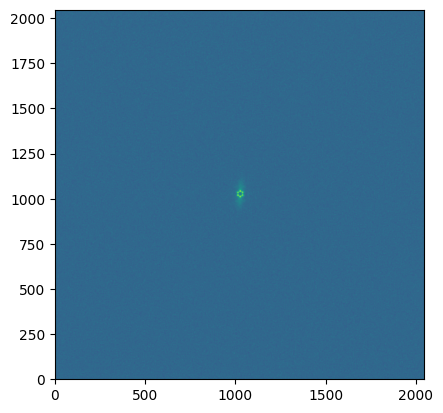

In [9]:
plt.imshow(cube_new[0,:,:],origin="lower")
plt.show()
fits.writeto("source_cube_processed.fits",cube_new,overwrite=True)
fits.writeto("source_cube_processed_ref.fits",cube_new_ref,overwrite=True)
fits.writeto("source_cube_processed_off.fits",cube_new_off,overwrite=True)
fits.writeto("source_cube_processed_bkg.fits",cube_new_bkg,overwrite=True)